<a href="https://colab.research.google.com/github/khizon/Bike_Share_Google_Data_Analytics/blob/main/Cyclistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study: How Does a Bike-Share Navigate Speedy Success?

Cyclistic is a fictional bicycle sharing company. For this case study, 14 months of trip data is used to determine the difference in use between annual members and casual users. This is to gain insights on how to convert casual users to annual members which is seen as the pathway to the company's growth.

Cyclistic is based upon a real company that have the following services on their website:


*   Casual users pay a flat fee everytime they start a trip and a usage fee per min after 30 mins.
*   Annual members pay an upfront cost. The first 45 mins of each trip is paid for by the plan and they incur usage fees after 45 mins.






# Importing Libraries

In [ ]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express
# Install Fiona
!pip install Fiona
# Install Contextily
!pip install Contextily
# Install Map Classify
!pip install mapclassify

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-4eb87xr8
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-4eb87xr8
CPU times: user 352 ms, sys: 94.5 ms, total: 447 ms
Wall time: 34.3 s


In [ ]:
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import mapclassify

# Importing the Data

The data is stored in an amazon bucket as zip files. The year-month is the identifier for their urls. The script below imports 12 months of data and concatenates them into one dataframe for analysis. This process ensures that the code will not be able to overwrite the source data by accident. If the folder structure of the amazon bucket will change, then the script will need adjustment. As shown below, the data has columns for rideable_type, start and end time, start and end station name, station id, station location, and finally, the member classification (casual vs. annual member)

In [ ]:
months = ['202007', '202008', '202009', '202010', '202011', '202012', '202101', '202102', '202103', '202104', '202105', '202106', '202107', '202108']

urls = [f'https://divvy-tripdata.s3.amazonaws.com/{month}-divvy-tripdata.zip' for month in months]


for i, url in enumerate(urls):
  filename = requests.get(url).content
  zf = ZipFile( BytesIO(filename), 'r' )
  match = [s for s in zf.namelist() if "MACOSX" not in s][0]
  if i == 0:
    print(f'{i}: {url}')
    df = pd.read_csv( zf.open(match), encoding='latin-1', error_bad_lines=False)
  else:
    print(f'{i}: {url}')
    temp = pd.read_csv( zf.open(match), encoding='latin-1', error_bad_lines=False)
    df = pd.concat([df, temp], ignore_index=True)

df.sort_values('started_at')

0: https://divvy-tripdata.s3.amazonaws.com/202007-divvy-tripdata.zip
1: https://divvy-tripdata.s3.amazonaws.com/202008-divvy-tripdata.zip
2: https://divvy-tripdata.s3.amazonaws.com/202009-divvy-tripdata.zip
3: https://divvy-tripdata.s3.amazonaws.com/202010-divvy-tripdata.zip
4: https://divvy-tripdata.s3.amazonaws.com/202011-divvy-tripdata.zip
5: https://divvy-tripdata.s3.amazonaws.com/202012-divvy-tripdata.zip
6: https://divvy-tripdata.s3.amazonaws.com/202101-divvy-tripdata.zip
7: https://divvy-tripdata.s3.amazonaws.com/202102-divvy-tripdata.zip
8: https://divvy-tripdata.s3.amazonaws.com/202103-divvy-tripdata.zip
9: https://divvy-tripdata.s3.amazonaws.com/202104-divvy-tripdata.zip
10: https://divvy-tripdata.s3.amazonaws.com/202105-divvy-tripdata.zip
11: https://divvy-tripdata.s3.amazonaws.com/202106-divvy-tripdata.zip
12: https://divvy-tripdata.s3.amazonaws.com/202107-divvy-tripdata.zip
13: https://divvy-tripdata.s3.amazonaws.com/202108-divvy-tripdata.zip


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
275150,C66CC4DD911DDFBD,docked_bike,2020-07-01 00:00:14,2020-07-01 01:28:12,Buckingham Fountain,2,Buckingham Fountain,2,41.876511,-87.620548,41.876511,-87.620548,casual
259045,BD6363747C00FAD3,docked_bike,2020-07-01 00:00:15,2020-07-01 02:44:58,Wells St & Concord Ln,289,Clark St & Lake St,38,41.912133,-87.634656,41.886021,-87.630876,casual
236929,1856297CBD809E60,docked_bike,2020-07-01 00:00:49,2020-07-01 00:45:04,Wabash Ave & Wacker Pl,194,Wabash Ave & Wacker Pl,194,41.886875,-87.626030,41.886875,-87.626030,casual
217019,06B27D89815F5031,docked_bike,2020-07-01 00:00:50,2020-07-01 02:52:16,Wells St & Concord Ln,289,Clark St & Lake St,38,41.912133,-87.634656,41.886021,-87.630876,casual
195188,7F17B8FF6F418A7F,docked_bike,2020-07-01 00:01:11,2020-07-01 00:08:03,State St & 33rd St,148,MLK Jr Dr & 29th St,237,41.834734,-87.625813,41.842052,-87.617000,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5717480,5DFCC9B26EA436B6,electric_bike,2021-08-31 23:59:02,2021-09-01 00:01:24,Wells St & Elm St,KA1504000135,Dearborn Pkwy & Delaware Pl,TA1307000128,41.902993,-87.634214,41.898995,-87.630102,member
5286872,448D1DCC9301FCF8,electric_bike,2021-08-31 23:59:04,2021-09-01 00:03:36,NaN,NaN,NaN,NaN,41.910000,-87.760000,41.910000,-87.760000,casual
5886394,696964CAEBC45937,electric_bike,2021-08-31 23:59:04,2021-09-01 00:02:16,Clark St & Berwyn Ave,KA1504000146,NaN,NaN,41.977997,-87.668037,41.990000,-87.670000,member
6033028,99571F638261030D,classic_bike,2021-08-31 23:59:09,2021-09-01 00:03:05,Lincoln Ave & Belmont Ave,TA1309000042,Lincoln Ave & Diversey Pkwy,TA1307000064,41.939365,-87.668385,41.932225,-87.658617,member


# Data Exploration and Cleaning

The `started_at` and `ended_at` columns are of string data type. The following block converts them to date time. Additional columns can also be computed such as trip duration and day of the week when the trip was started. Note that Monday = 0 and Sunday = 7.

In [ ]:
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['trip_duration'] = df['ended_at']-df['started_at']
df['day_of_week'] = df['started_at'].dt.dayofweek
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration,day_of_week
0,762198876D69004D,docked_bike,2020-07-09 15:22:02,2020-07-09 15:25:52,Ritchie Ct & Banks St,180,Wells St & Evergreen Ave,291,41.906866,-87.626217,41.906724,-87.634830,member,0 days 00:03:50,3
1,BEC9C9FBA0D4CF1B,docked_bike,2020-07-24 23:56:30,2020-07-25 00:20:17,Halsted St & Roscoe St,299,Broadway & Ridge Ave,461,41.943670,-87.648950,41.984045,-87.660274,member,0 days 00:23:47,4
2,D2FD8EA432C77EC1,docked_bike,2020-07-08 19:49:07,2020-07-08 19:56:22,Lake Shore Dr & Diversey Pkwy,329,Clark St & Wellington Ave,156,41.932588,-87.636427,41.936497,-87.647539,casual,0 days 00:07:15,2
3,54AE594E20B35881,docked_bike,2020-07-17 19:06:42,2020-07-17 19:27:38,LaSalle St & Illinois St,181,Clark St & Armitage Ave,94,41.890762,-87.631697,41.918306,-87.636282,casual,0 days 00:20:56,4
4,54025FDC7440B56F,docked_bike,2020-07-04 10:39:57,2020-07-04 10:45:05,Lake Shore Dr & North Blvd,268,Clark St & Schiller St,301,41.911722,-87.626804,41.907993,-87.631501,member,0 days 00:05:08,5


In [ ]:
df.dtypes

ride_id                        object
rideable_type                  object
started_at             datetime64[ns]
ended_at               datetime64[ns]
start_station_name             object
start_station_id               object
end_station_name               object
end_station_id                 object
start_lat                     float64
start_lng                     float64
end_lat                       float64
end_lng                       float64
member_casual                  object
trip_duration         timedelta64[ns]
day_of_week                     int64
dtype: object

# Handling Missing, Duplicate, and Erroneous data

The following section will handle missing data in our dataset. There are more than 300,000 (5%) entries that are missing location names and ids. This is a significant portion, however, there are only 6,000 (0.1%) that are missing end of trip coordinates. Spatial analysis can still be done on those that have missing station names and ids as long as they have coordinates. Rows with missing coordinates will be dropped.

In [ ]:
df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    457789
start_station_id      458414
end_station_name      502382
end_station_id        502843
start_lat                  0
start_lng                  0
end_lat                 6723
end_lng                 6723
member_casual              0
trip_duration              0
day_of_week                0
dtype: int64

In [ ]:
df[df['end_lat'].isnull()].groupby('member_casual').ride_id.count()

member_casual
casual    3987
member    2736
Name: ride_id, dtype: int64

In [ ]:
df.dropna(subset = ['end_lat', 'end_lng'],inplace=True)
df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    457789
start_station_id      458414
end_station_name      495659
end_station_id        496120
start_lat                  0
start_lng                  0
end_lat                    0
end_lng                    0
member_casual              0
trip_duration              0
day_of_week                0
dtype: int64

Next, rows with trip durations that are in the negative is considered erroenous and are dropped

In [ ]:
df.loc[df['trip_duration']<pd.Timedelta(0)]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration,day_of_week
347,46690D1DABBC0686,docked_bike,2020-07-06 17:54:13,2020-07-06 17:54:11,Streeter Dr & Grand Ave,35,Lake Shore Dr & Monroe St,76,41.892278,-87.612043,41.880958,-87.616743,casual,-1 days +23:59:58,0
592,EA4DB37907A27926,docked_bike,2020-07-13 17:59:10,2020-07-13 17:59:05,Wilton Ave & Belmont Ave,117,Lakefront Trail & Bryn Mawr Ave,459,41.940180,-87.653040,41.984037,-87.652310,member,-1 days +23:59:55,0
710,5D3B8C073B49CC1D,docked_bike,2020-07-21 06:45:19,2020-07-21 06:44:47,Wabash Ave & Grand Ave,199,Clinton St & Jackson Blvd,638,41.891466,-87.626761,41.878116,-87.639838,member,-1 days +23:59:28,1
892,D0291C4CE49D5F9F,docked_bike,2020-07-13 20:26:24,2020-07-13 20:26:23,Shedd Aquarium,3,MLK Jr Dr & 29th St,237,41.867225,-87.615355,41.842052,-87.617000,member,-1 days +23:59:59,0
957,D391EC6989FF6BEA,docked_bike,2020-07-23 13:07:07,2020-07-23 13:06:53,Southport Ave & Wellington Ave,153,Sheffield Ave & Wellington Ave,115,41.935733,-87.663576,41.936266,-87.652662,member,-1 days +23:59:46,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5853605,9200647C37FD38B0,classic_bike,2021-08-20 16:16:58,2021-08-20 16:14:11,Sheffield Ave & Waveland Ave,TA1307000126,Sheffield Ave & Waveland Ave,TA1307000126,41.949399,-87.654529,41.949399,-87.654529,member,-1 days +23:57:13,4
5899309,4F67BFFB680CEDCD,electric_bike,2021-08-10 20:54:18,2021-08-10 20:51:38,NaN,NaN,NaN,NaN,41.890000,-87.630000,41.890000,-87.630000,member,-1 days +23:57:20,1
5933109,D35A56D5648A785A,electric_bike,2021-08-11 06:12:16,2021-08-11 06:11:04,NaN,NaN,NaN,NaN,41.890000,-87.620000,41.890000,-87.620000,member,-1 days +23:58:48,2
5957465,9121D4C66D81CDA2,electric_bike,2021-08-30 13:13:15,2021-08-30 13:11:28,Clark St & Montrose Ave,KA1503000022,NaN,NaN,41.961580,-87.666367,41.960000,-87.670000,casual,-1 days +23:58:13,0


In [ ]:
df = df.drop(df[df.trip_duration<pd.Timedelta(0)].index)

`ride_id` is assumed to uniquely identify each trip. Having because the number of unique `ride_id` is the same as the number of rows, there are no duplicated trips in the dataset.

In [ ]:
# print(df.nunique())
# print(len(df.index))
print(f'Unique ride_id: {df.nunique().ride_id}\nData Rows: {len(df.index)}')

# Data Analysis

The distribution of data will be analyzed to see patterns and outliers. The data is almost equally divided between members and casual riders. On average, casual riders ride longer (37 minutes) compared to annual members (15 minutes). It is interesting that the mean trip duration for casual riders is above the 75th percentile. There are very long trips that pull the average really high.

In [ ]:
df_cleaned = df
df_cleaned.groupby('member_casual').ride_id.count()

member_casual
casual    2777040
member    3293260
Name: ride_id, dtype: int64

In [ ]:
df_cleaned['trip_duration_m'] = (df_cleaned['trip_duration']/np.timedelta64(1, 'm')) # convert time deltas to minutes
df_cleaned.groupby('member_casual').trip_duration_m.mean()

member_casual
casual    36.689239
member    14.656500
Name: trip_duration_m, dtype: float64

Text(0.5, 1.0, 'Trip Duration')

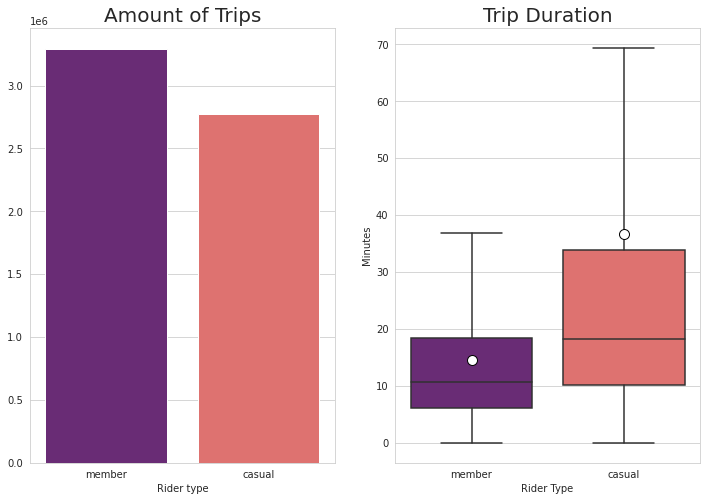

In [ ]:
sns.set_style('whitegrid')
unique = df_cleaned['member_casual'].unique()
palette = dict(zip(unique, sns.color_palette('magma',n_colors=len(unique))))
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,8))
p1 = sns.countplot(ax = ax1, x = 'member_casual', data = df_cleaned, palette = palette)
p1.set_xlabel('Rider type')
p1.set_ylabel('')
p1.set_title('Amount of Trips', fontsize = 20)
p2 = sns.boxplot(ax= ax2, x="member_casual", y="trip_duration_m", data=df_cleaned,
                 showfliers = False, showmeans = True,
                 meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
                 palette = 'magma')
p2.set_xlabel('Rider Type')
p2.set_ylabel('Minutes')
p2.set_title('Trip Duration', fontsize =20)


# Weekly Trend
To analyze day by day trends, pivot tables is used to group the data by day of the week and compare annual members and casual riders.

## Counting Trips

By amount of trips, members outnumber casual riders during weekdays but it is reversed during weekends.

In [ ]:
table = pd.pivot_table(df_cleaned, values='ride_id', index=['day_of_week'],
                    columns=['member_casual'], aggfunc=lambda x: len(x.unique()))
table

member_casual,casual,member
day_of_week,,
0,306862,443135
1,296247,479191
2,301500,493630
3,315615,481753
4,410522,490886
5,624963,486302
6,521331,418363


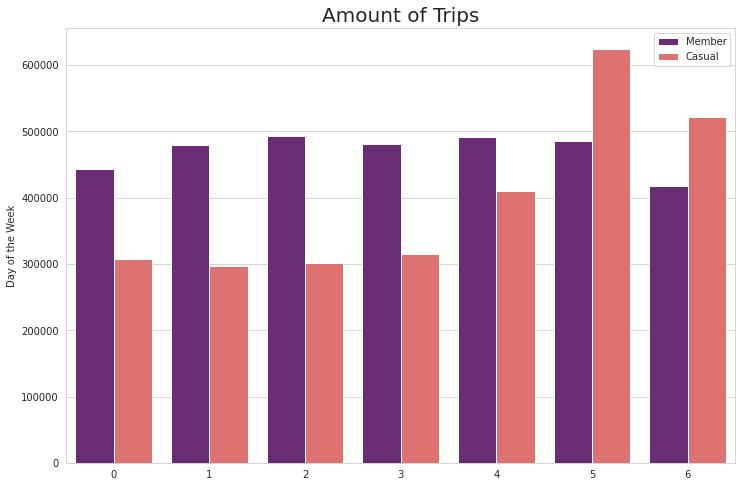

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))

p = sns.countplot(ax = ax, x = 'day_of_week', hue = 'member_casual', data = df_cleaned, palette = palette)
p.set_xlabel('')
p.set_ylabel('Day of the Week')
p.set_title('Amount of Trips', fontsize = 20)
p.legend(['Member', 'Casual'])

## Analyzing Trip Duration

Mean trip duration for members almost stays constant below 20 minutes. Casual riders' trips are longer on average and exceed 30 minutes during the weekends.

In [ ]:
table = pd.pivot_table(df_cleaned, values='trip_duration_m', index=['day_of_week'],
                    columns=['member_casual'], aggfunc=np.mean)
table

member_casual,casual,member
day_of_week,,
0,36.075315,14.100088
1,32.255875,13.788683
2,33.120038,13.906264
3,33.133039,13.819434
4,34.885415,14.410204
5,39.286634,16.189826
6,42.093673,16.595625


Text(0.5, 1.0, 'Trip Duration')

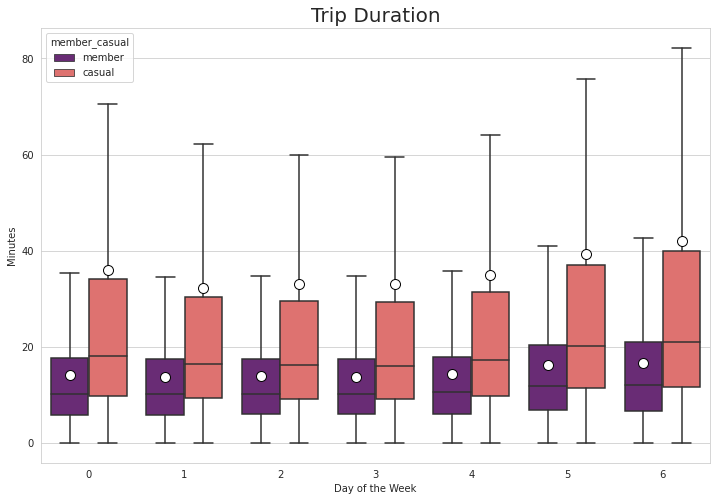

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
p = sns.boxplot(ax= ax,x="day_of_week", y="trip_duration_m", hue="member_casual",
                 data=df_cleaned, showmeans = True, showfliers = False,
                meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
                palette = palette)
p.set_ylabel('Minutes')
p.set_xlabel('Day of the Week')
p.set_title('Trip Duration', fontsize = 20)

## Above Average Trip Durations

Filtering only the trips that exceed the average, casual riders always outnumber members and the gap increases significantly during weekends.

In [ ]:
trip_mean = int(np.round(df_cleaned['trip_duration_m'].mean()))
trip_mean

25

In [ ]:
df_cleaned['above_mean'] = df_cleaned['trip_duration'] > np.timedelta64(trip_mean,'m')
table = pd.pivot_table(df_cleaned, values='ride_id', index=['day_of_week'],
                    columns=['member_casual', 'above_mean'], aggfunc=lambda x: len(x.unique()))
table


member_casual  casual          member       
above_mean      False   True    False  True 
day_of_week                                 
0              194761  112101  384745  58390
1              200213   96034  418635  60556
2              207231   94269  431012  62618
3              218061   97554  421944  59809
4              271739  138783  424880  66006
5              372232  252731  400998  85304
6              299180  222151  341179  77184

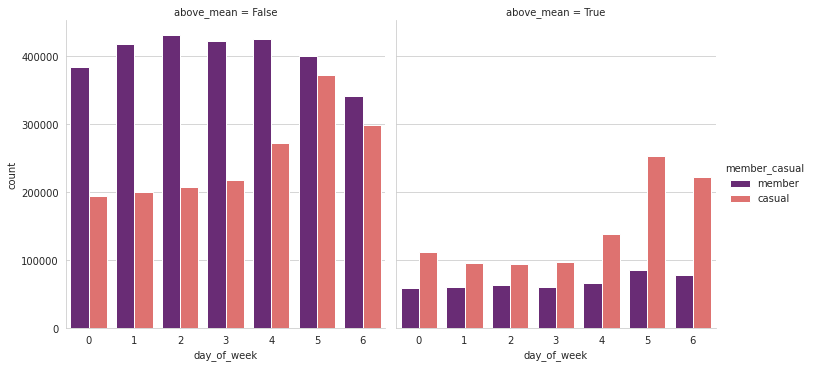

In [ ]:
p = sns.catplot(x='day_of_week', hue='member_casual', col='above_mean',
                data=df_cleaned, kind="count", palette = palette)

# Monthly/Seasonal Analysis

In this section, similar analysis as done above will be done but the trips will be grouped by year of the month.

In [ ]:
df_cleaned['month'] = df['started_at'].dt.to_period('M')

In [ ]:
df_cleaned.dtypes

ride_id                        object
rideable_type                  object
started_at             datetime64[ns]
ended_at               datetime64[ns]
start_station_name             object
start_station_id               object
end_station_name               object
end_station_id                 object
member_casual                  object
trip_duration         timedelta64[ns]
day_of_week                     int64
trip_duration_m               float64
month                       period[M]
start_point                  geometry
end_point                    geometry
geometry                     geometry
dtype: object

## Amount of Trips

There is a decline in the amount of trips during the winter months. The decline is stronger for casual riders. Starting March 2021, trips significantly grew but there is greater increase in casual trips as it surpassed annual members June 2021. There is a slight decrease on casual trips for August 2021.

In [ ]:
table = pd.pivot_table(df_cleaned, values='ride_id', index=['month'],
                    columns=['member_casual'], aggfunc=lambda x: len(x.unique()))
table

member_casual,casual,member
month,,
2020-07,268286,280680
2020-08,288075,330584
2020-09,229748,300294
2020-10,144350,241926
2020-11,87819,170751
2020-12,29962,101067
2021-01,18095,78635
2021-02,10073,39335
2021-03,83922,144405


Text(0.5, 1.0, 'Amount of Trips')

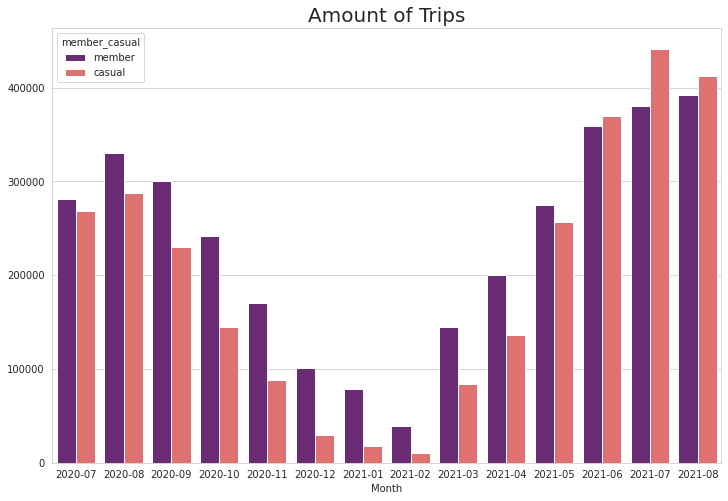

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
p = sns.countplot(ax = ax, x = 'month', hue = 'member_casual', data = df_cleaned, palette = palette)
p.set_xlabel('Month')
p.set_ylabel('')
p.set_title('Amount of Trips', fontsize = 20)

## Analyzing Trip Duration

Annual members' trip duration are more constant over time while casual riders have huge variations. Casual riders still tend to have longer average trips. Casual riders' trips are declining and July 2021 is about half of July 2020.

In [ ]:
table = pd.pivot_table(df_cleaned, values='trip_duration_m', index=['member_casual'],
                    columns=['month'], aggfunc=np.mean)
table

month,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08
member_casual,,,,,,,,,,,,,,
casual,59.268001,44.020536,37.641109,29.734082,31.363748,25.803874,24.467703,44.446640,36.880999,36.608247,36.976015,35.645913,31.435850,27.418082
member,17.573723,16.611616,15.332721,13.877618,13.426232,12.490257,12.494131,15.484679,13.793440,14.454710,14.426302,14.336713,14.005666,13.831938


Text(0.5, 1.0, 'Trip Duration')

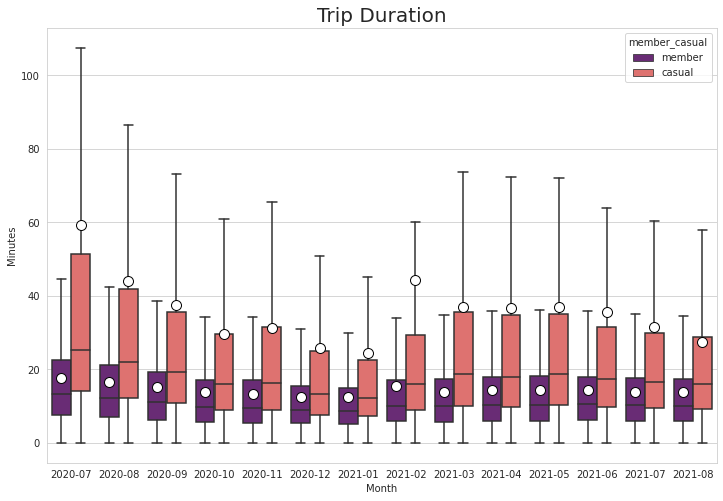

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
p = sns.boxplot(ax= ax,x="month", y="trip_duration_m", hue="member_casual",
                 data=df_cleaned, showmeans = True, showfliers = False,
                meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
                palette = palette)
p.set_ylabel('Minutes')
p.set_xlabel('Month')
p.set_title('Trip Duration', fontsize = 20)

# Combined Day of the Week and Monthly Analysis

## Amount of Trips
Focusing only on the casual riders, the plot below shows the decline in trips during the winter months and increase during the summer. The growth is very pronounced on Saturdays as trips exceeded 100,000 on July 2021

In [ ]:
table = pd.pivot_table(df_cleaned[df_cleaned['member_casual'] == 'casual'], values='ride_id', index=['day_of_week'],
                    columns=['month'], aggfunc=lambda x: len(x.unique()))
table

month,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08
day_of_week,,,,,,,,,,,,,,
0,27749,28980,27441,10219,10857,3538,2086,581,11975,16007,34379,35034,48238,49778
1,26131,28198,22525,14284,8264,3973,1880,999,10453,20355,18572,48011,45346,47256
2,30608,29372,29679,16563,8396,4611,2091,1114,8875,11978,23129,48620,46488,39976
3,37173,30916,23846,19619,10307,4709,2345,1039,5479,12331,22811,41363,56770,46907
4,49728,39077,32865,23680,13370,3459,2832,1482,7768,22883,30399,52707,71867,58405
5,53675,73188,49382,38563,20871,4564,3999,3474,22056,27694,65209,75617,103108,83563
6,43222,58344,44010,21422,15754,5108,2862,1384,17316,25166,62078,68801,69648,86216


Text(0.5, 1.0, 'Amount of Casual Rider Trips')

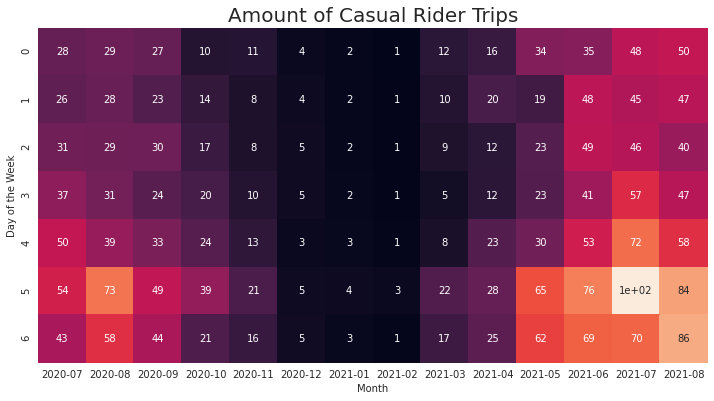

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
p = sns.heatmap(table, cmap="rocket", ax = ax, annot = np.round(table.values/1000, decimals = 0), square = True, cbar = False)
p.set_ylabel('Day of the Week')
p.set_xlabel('Month')
p.set_title('Amount of Casual Rider Trips', fontsize = 20)

## Trip Duration

As for the duration of trips, casual rides are half of previous year's durations but there is still the slight uptick during weekends. In this plot we can see that the outliers on trip durations for Feb 2021 happened during Fridays and Saturdays

In [ ]:
table = pd.pivot_table(df_cleaned[df_cleaned['member_casual'] == 'casual'], values='trip_duration_m', index=['day_of_week'],
                    columns=['month'], aggfunc=np.mean)
table

month,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08
day_of_week,,,,,,,,,,,,,,
0,61.513179,42.412344,38.618510,24.153895,27.046314,21.857236,19.079099,34.350201,42.940521,35.580712,36.403777,29.361474,34.873036,27.134113
1,51.691101,40.262423,29.257026,28.657060,26.827241,20.982008,21.512030,40.587588,35.015071,38.526627,29.451188,31.947458,26.848004,24.690504
2,56.603299,39.236909,35.136287,26.224427,24.507390,21.674283,24.338969,26.419913,27.866195,37.119593,29.904726,33.300584,27.291017,24.168020
3,57.078550,42.382742,31.106100,23.347210,28.432991,23.160225,19.940490,20.825024,28.775041,23.221655,30.871544,33.536878,29.269078,24.684344
4,52.480868,40.581750,35.661958,30.949837,29.783790,22.101041,21.520986,53.946300,28.272981,38.970061,33.629016,34.970793,29.304049,26.064708
5,62.245323,46.656146,41.262032,33.745628,35.414305,27.944975,30.814183,58.734993,40.752069,35.326239,37.773389,39.846826,33.725150,29.120293
6,70.288844,48.908746,43.967885,33.111742,38.264996,39.047236,28.188289,37.676132,39.932945,41.289277,45.223290,40.252306,35.385585,31.338327


Text(0.5, 1.0, 'Average Trip Duration')

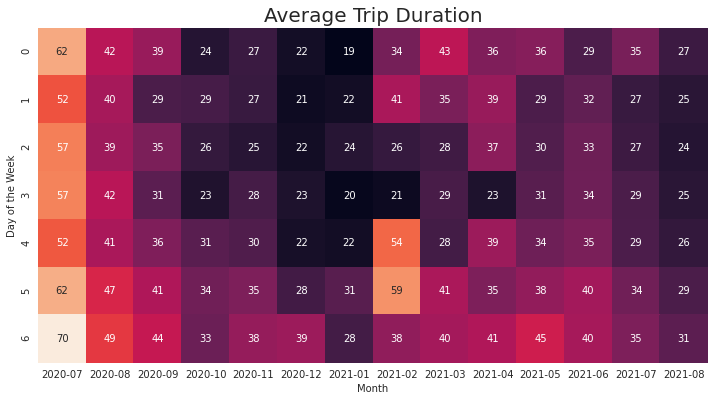

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
p = sns.heatmap(table, cmap="rocket", ax = ax, annot = np.round(table.values, decimals = 2), square = True, cbar = False)
p.set_ylabel('Day of the Week')
p.set_xlabel('Month')
p.set_title('Average Trip Duration', fontsize = 20)

# Geographical Analysis

On this section, geopandas will be used visualize the geographic distribution of the trips.

In [ ]:
df['start_point'] = gpd.points_from_xy(df.start_lng, df.start_lat)
df['end_point'] = gpd.points_from_xy(df.end_lng, df.end_lat)
df.drop(columns = ['start_lat', 'start_lng', 'end_lat', 'end_lng'], inplace=True)

df.dtypes

ride_id                        object
rideable_type                  object
started_at             datetime64[ns]
ended_at               datetime64[ns]
start_station_name             object
start_station_id               object
end_station_name               object
end_station_id                 object
member_casual                  object
trip_duration         timedelta64[ns]
day_of_week                     int64
trip_duration_m               float64
month                       period[M]
start_point                  geometry
end_point                    geometry
dtype: object

We import a shape file of Chicago that is subdivided by communities.

In [ ]:
chicago_areas = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/DATA _ANALYTICS/chicago_areas.shp')
chicago_areas.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Since the earth is not flat, there are multiple projections available and some we need to ensure that we are using the same one.

In [ ]:
gdf_start = gpd.GeoDataFrame(
    df, geometry=df['start_point'], crs = chicago_areas.crs )

gdf_start.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
gdf_end = gpd.GeoDataFrame(
    df, geometry=df['end_point'], crs = chicago_areas.crs )

gdf_end.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Distance Computation

The distance between the start and end points is computed. The computed values are very low in average. This show that users take the bike, use it around the city, and return it to almost the same spot. It is unfortunate that actual trip distance is not included in the data.

In [ ]:
s1 = gpd.GeoSeries(gdf_start.geometry)
s2 = gpd.GeoSeries(gdf_end.geometry)

df_cleaned['distance'] = s1.distance(s2)

df_cleaned[['ride_id','start_point', 'end_point', 'distance']].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


,ride_id,start_point,end_point,distance
0,762198876D69004D,POINT (-87.62622 41.90687),POINT (-87.63483 41.90672),0.008614
1,BEC9C9FBA0D4CF1B,POINT (-87.64895 41.94367),POINT (-87.66027 41.98404),0.041933
2,D2FD8EA432C77EC1,POINT (-87.63643 41.93259),POINT (-87.64754 41.93650),0.011779
3,54AE594E20B35881,POINT (-87.63170 41.89076),POINT (-87.63628 41.91831),0.027923
4,54025FDC7440B56F,POINT (-87.62680 41.91172),POINT (-87.63150 41.90799),0.005997


In [ ]:
df_cleaned[['ride_id','start_point', 'end_point', 'distance', 'trip_duration_m']].sort_values('distance', ascending=False).head(20)

,ride_id,start_point,end_point,distance,trip_duration_m
2230168,F0815842E54C9D55,POINT (-87.71530 42.06485),POINT (-87.54609 41.64850),0.449423,308.800000
2840118,28200FEEB3BB697B,POINT (-87.71675 41.93532),POINT (-88.07000 42.00000),0.359120,88.100000
3386944,28827E4E56FC0AE6,POINT (-87.66029 41.99478),POINT (-87.68130 41.69121),0.304295,1261.850000
5483575,CB1D383383F0F1EB,POINT (-87.53481 41.71275),POINT (-87.66027 41.98405),0.298901,116.700000
3885981,3FD15C24064A9BB5,POINT (-87.64000 41.93000),POINT (-87.53956 41.65192),0.295664,128.983333
2203287,C2E6A48EFCBF1F24,POINT (-87.65975 41.97835),POINT (-87.53481 41.71275),0.293522,156.433333
4423070,79B7F88BF7309475,POINT (-87.53959 41.65190),POINT (-87.63905 41.92587),0.291454,78.900000
4584167,05E2FF8AEAEBD69B,POINT (-87.66037 41.99473),POINT (-87.65714 41.70506),0.289686,146.133333
2310671,9C1A4D355879D2B4,POINT (-87.63000 41.72000),POINT (-87.73000 41.99000),0.287924,94.283333
3284615,799A0D945DD36C9A,POINT (-87.68666 42.05695),POINT (-87.58080 41.79520),0.282340,153.033333


In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
p = sns.boxplot(ax= ax,x="month", y="distance", hue="member_casual",
                 data=df_cleaned, showmeans = True, showfliers = False,
                meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
                palette = palette)
p.set_ylabel('Distance')
p.set_xlabel('Month')
p.set_title('Trip Distance', fontsize = 20)

## Grouping our trips by Community

The data are a bunch of geographic points. This section will aggregate them according to the community in which they fall.

The data has a geometry column filled with points (longitude and latitude). The map has a geometry column with polygons (community boundaries). Spatial join will merge these two and retain the polygons as geometry.

In [ ]:
gdf_to_join = gdf_start[['ride_id', 'geometry', 'trip_duration_m', 'day_of_week', 'month' , 'member_casual']]
gdf_joined = gpd.sjoin(chicago_areas[['community', 'geometry']], gdf_to_join[gdf_to_join['member_casual'] == 'casual'])
gdf_joined[['ride_id', 'community', 'geometry']]

,ride_id,community,geometry
0,60710371A15481FD,DOUGLAS,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
0,E3A472F33EE0D769,DOUGLAS,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
0,A1335D66E569836A,DOUGLAS,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
0,C97D46BA55AE5183,DOUGLAS,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
0,64E238B0418212A5,DOUGLAS,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
...,...,...,...
75,24DD9F9C2F434808,EDGEWATER,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."
75,034FB6B0F10A4241,EDGEWATER,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."
75,93798B389C92917E,EDGEWATER,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."
75,0823A54613C5A51B,EDGEWATER,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."


## Amount of Trips

The block below will count the amount of monthly trips and take the monthly average. Unfortunately, this will remove the geometry column so it has to be merged again on the block below. Geopandas has a function that combines these two steps called `dissolve`, but it takes more time to run. 

In [ ]:
table = pd.pivot_table(gdf_joined, values='ride_id', index=['community'],
                    columns = 'month', aggfunc=lambda x: len(x.unique()))

table['monthly_average'] = table.mean(axis =1)
table.reset_index(inplace=True)
chi_map_trips = chicago_areas[['community', 'geometry']].merge(table, on = 'community')
chi_map_trips
top_areas = chi_map_trips[chi_map_trips['monthly_average']>500]
top_areas[['community', 'monthly_average']].sort_values('monthly_average', ascending = False)

,community,monthly_average
36,NEAR NORTH SIDE,40381.500000
37,LOOP,29522.214286
67,LINCOLN PARK,29347.500000
44,LAKE VIEW,20856.928571
24,WEST TOWN,13610.928571
28,NEAR WEST SIDE,12503.642857
22,LOGAN SQUARE,7062.357143
33,NEAR SOUTH SIDE,6741.500000
30,UPTOWN,6190.214286
7,HYDE PARK,3988.000000


In [ ]:
top_areas = top_areas.community.to_list()

The map below shows the distribution of monthly average trips geographically. Communities with more that 500 monthly average trips are focused.

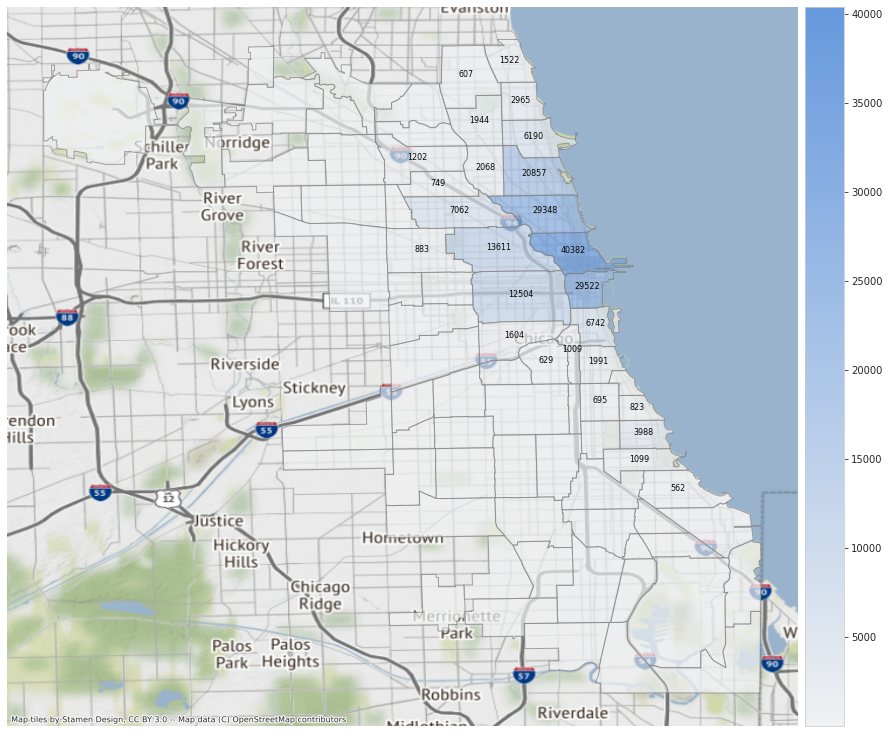

In [ ]:
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1,1, figsize = (15,18))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
chi_map_trips.plot(figsize = (15,18), column = 'monthly_average', cmap = sns.color_palette("light:#69d", as_cmap=True), 
             edgecolor = '#808080', alpha = 0.7, legend = True,
             ax = ax, cax = cax)
chi_map_trips[chi_map_trips['community'].isin(top_areas)].apply(lambda x: ax.annotate(s=int(np.round(x.monthly_average, decimals = 0)), xy=x.geometry.centroid.coords[0], ha='center', size=8, color = '#080808'),axis=1)
ctx.add_basemap(ax, crs = chicago_areas.crs)
ax.set_axis_off()

## Trip Duration

Because of the drop of trip durations compared to last year, this section will only consider trips made since March 2021 and on weekends.

In [ ]:
table = pd.pivot_table(gdf_joined[(gdf_joined['month']>'2021-03') & (gdf_joined['day_of_week']> 4)], values='trip_duration_m', index=['community'],
                    aggfunc=np.mean)
table.reset_index(inplace=True)

In [ ]:
chi_map_time = chicago_areas[['community', 'geometry']].merge(table, on = 'community')
chi_map_time = chi_map_time[chi_map_time['trip_duration_m']>40]
chi_map_time

,community,geometry,trip_duration_m
0,DOUGLAS,"POLYGON ((-87.60914 41.84469, -87.60915 41.844...",64.260894
3,GRAND BOULEVARD,"POLYGON ((-87.60671 41.81681, -87.60670 41.816...",42.557232
4,KENWOOD,"POLYGON ((-87.59215 41.81693, -87.59215 41.816...",47.577471
6,WASHINGTON PARK,"POLYGON ((-87.60604 41.78587, -87.60627 41.785...",47.737769
7,HYDE PARK,"POLYGON ((-87.58038 41.80253, -87.58040 41.802...",41.789565
8,WOODLAWN,"POLYGON ((-87.57714 41.78615, -87.57714 41.786...",60.328129
9,ROGERS PARK,"POLYGON ((-87.65456 41.99817, -87.65574 41.998...",49.218220
11,FOREST GLEN,"POLYGON ((-87.76919 42.00489, -87.76919 42.004...",44.455833
12,NORTH PARK,"POLYGON ((-87.70690 41.98308, -87.70688 41.983...",53.518588
15,IRVING PARK,"POLYGON ((-87.69475 41.96127, -87.69472 41.961...",41.137654


The map below show where the casual weekend trips are above 40 mins during weekends.

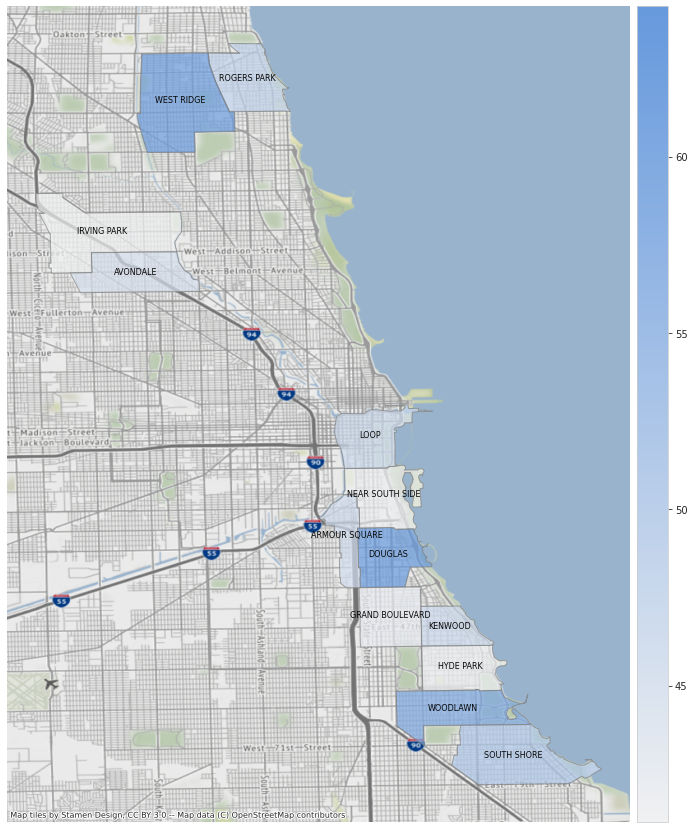

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (13,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
chi_map_time[chi_map_time['community'].isin(top_areas)].plot(figsize = (15,18), column = 'trip_duration_m', cmap = sns.color_palette("light:#69d", as_cmap=True), 
             edgecolor = '#808080', alpha = 0.7, legend = True,
             ax = ax, cax = cax)
chi_map_time[chi_map_time['community'].isin(top_areas)].apply(lambda x: ax.annotate(s=x.community, xy=x.geometry.centroid.coords[0], ha='center', size=8, color = '#080808'),axis=1)
ctx.add_basemap(ax, crs = chicago_areas.crs)
ax.set_axis_off()

# Summary of Findings

The analysis show that: 


*   There are more riders during warmer months.
*   Casual riders outnumber annual members during weekends.  
*   Casual riders have longer average trip durations
*   Most rides are concentrated at/near the central business district and radiate out from there

Actions that can be implemented

* **Launch a limited time promotion for new annual members during spring with a lower upfront payment.** The data show that warmer months corellate with more trips. Catching these influx of riders with a lower upfront payment atleast for the first year can encourage them to be an annual member.
* **Increase the included time during Spring-Summer weekends for new members.** The data has shown an uptick in ride duration and casual riders during weekends. At the time of writing, the included minutes for members is at 45 minutes and is a
* **Reserve a number of bicycles to members only for the most popular locations during summer weekends** This time period has the highest demand 
